## CNN for Image Classification
https://keras.io/examples/vision/image_classification_from_scratch
https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb
https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_from_scratch.py

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model.
We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.


We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.get_logger().setLevel('ERROR')

## Load the Dataset

In [5]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
dataset_archive = tf.keras.utils.get_file('kagglecatsanddogs_5340.zip', dataset_url, extract=True, cache_dir='.')

824887076/824887076 [==============================] - 25s 0us/step


In [6]:
dataset_path = './datasets/PetImages'

In [7]:
# Filter out corrupted images
# When working with lots of real-world image data, corrupted images are a common occurence.
# Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
# Generate a Dataset
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


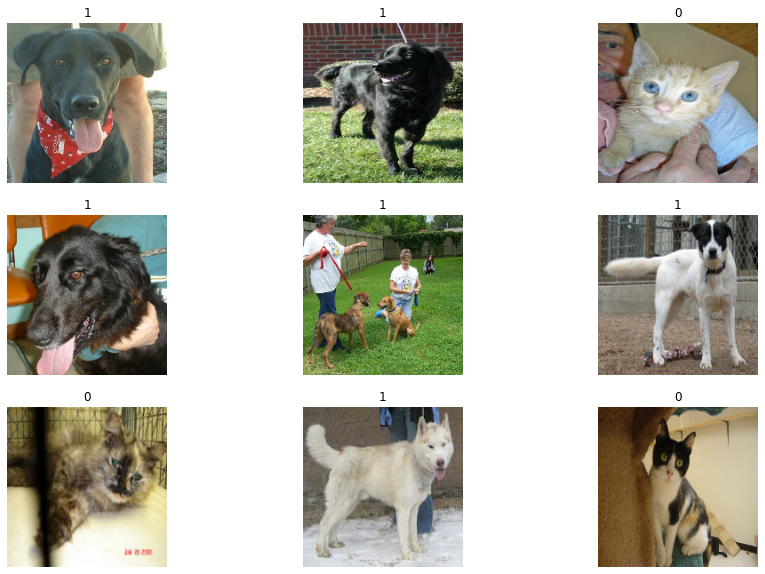

In [9]:
# Visualize the data
# Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".
rows = 3
cols = 3
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
# show the figure
plt.show()

# Image Data Augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations.
This helps expose the model to different aspects of the training data while slowing down overfitting.

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tfl.RandomFlip("horizontal"),
        tfl.RandomRotation(0.1),
    ]
)

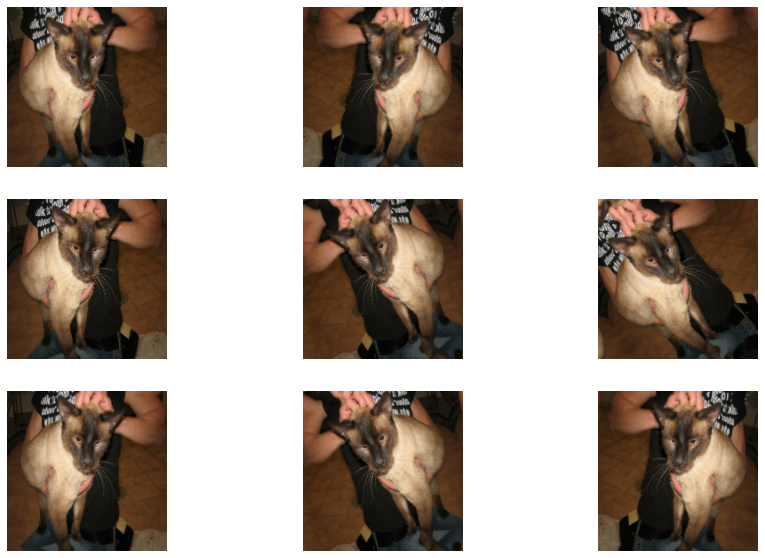

In [11]:
# Visualize augmented samples
rows = 3
cols = 3
plt.figure(figsize=(15, 10))
for images, _ in train_ds.take(1):
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
# show the figure
plt.show()

# Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

## Step 1: Define the Model
We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

In [13]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = tfl.Rescaling(1.0 / 255)(inputs)
    x = tfl.Conv2D(128, 3, strides=2, padding="same")(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tfl.Activation("relu")(x)
        x = tfl.SeparableConv2D(size, 3, padding="same")(x)
        x = tfl.BatchNormalization()(x)

        x = tfl.Activation("relu")(x)
        x = tfl.SeparableConv2D(size, 3, padding="same")(x)
        x = tfl.BatchNormalization()(x)

        x = tfl.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tfl.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = tfl.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tfl.SeparableConv2D(1024, 3, padding="same")(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Activation("relu")(x)

    x = tfl.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tfl.Dropout(0.5)(x)
    outputs = tfl.Dense(units, activation=activation)(x)

    return tf.keras.Model(inputs, outputs)

In [14]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

In [15]:
# summarize the model
# model.summary()

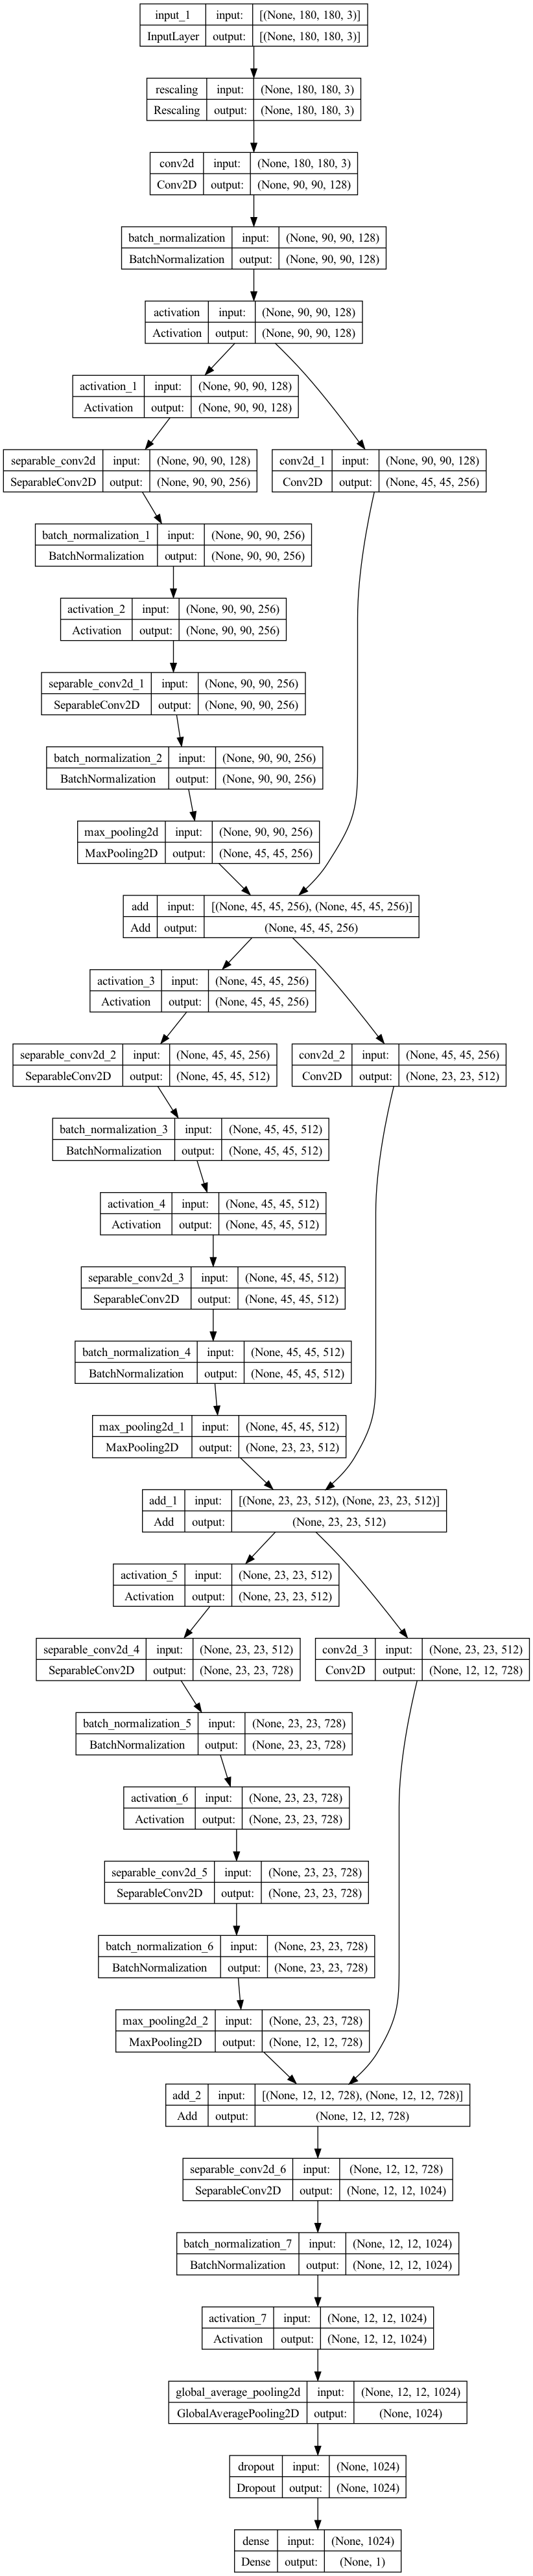

In [16]:
# Visualize the model
plot_model(model, 'model.png', show_shapes=True)

## Step 2: Compile the Model

In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

## Step 3: Fit the Model

In [ ]:
epochs = 25
sv = ModelCheckpoint("save_at_{epoch}.keras")
# Configure early stopping to stop training when a monitored metric has stopped improving.
es = EarlyStopping(monitor='val_loss', patience=5)
# Fit the model
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[es,sv], verbose=2)

Epoch 1/25


In [ ]:
# Plot learning curves
# The cross-entropy loss for the training dataset is accessed via the 'loss' key
# The loss on the validation dataset is accessed via the 'val_loss' key on the history attribute of the history object.
plt.figure(figsize=(12,10))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## Step 4: Evaluate the Model

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

In [ ]:
# Save model to file
model.save('model.h5')

## Step 5: Make Prediction

In [ ]:
# load the model from file
the_model = load_model('model.h5')

In [ ]:
# Make a prediction
img = tf.keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = the_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.imshow(img)
# show the figure
plt.show()